In [1]:
import os

from sklearn.metrics import r2_score, mean_squared_error, mean_absolute_error
from sklearn.model_selection import KFold, StratifiedKFold
from sklearn.preprocessing import StandardScaler
from torch import optim
from torch.utils.data import TensorDataset, DataLoader

from NeuralNet import Net

import torch
import torch.nn as nn
import matplotlib.pyplot as plt
import numpy as np

from data import processing_data
from evaluation import visualize_results
from settings import BASE_DIR, DEVICE
import pandas as pd

In [2]:
data_path = os.path.join(BASE_DIR,"dataset", 'train.csv')

df = pd.read_csv(data_path)
df

,genres,rating,no_of_votes,meta_score,release_date,gross,budget,countries,log_budget,log_no_of_votes,log_gross,log_gross_bin
0,"Period Drama, Biography, Drama, History, Music...",7.2,556,64.812903,2025.0,11625735.0,26000000.0,Russia,17.073607,6.322565,16.268732,2
1,"Caper, Film Noir, Action, Crime, Drama",8.1,37000,89.000000,1949.0,5534.0,1300000.0,United States,14.077876,10.518700,8.618847,0
2,"Classical Western, Drama, Romance, Western",7.7,27000,64.812903,1946.0,15293.0,2000000.0,United States,14.508658,10.203629,9.635216,0
3,"Dark Comedy, Comedy, Drama, Sport",6.8,92000,64.000000,2012.0,6985158.0,12000000.0,"United States, Canada",16.300417,11.429555,15.759298,1
4,"Coming-of-Age, Psychological Horror, Drama, Ho...",5.8,34000,86.000000,2024.0,5396508.0,26000000.0,"United States, United Kingdom",17.073607,10.434145,15.501263,1
...,...,...,...,...,...,...,...,...,...,...,...,...
1795,"Epic, Period Drama, Biography, Drama, Romance,...",7.4,30000,80.000000,2020.0,4645140.0,26000000.0,"United Kingdom, Germany, United States",17.073607,10.308986,15.351332,1
1796,"Comedy, Drama",7.5,189000,51.000000,2023.0,113360085.0,50000000.0,"United States, Sweden, Canada, Ireland, United...",17.727534,12.149508,18.546080,5
1797,"Raunchy Comedy, Comedy",7.0,250000,54.000000,2003.0,87135520.0,24000000.0,United States,16.993564,12.429220,18.282975,5
1798,"Classic Musical, Musical, Romance, Western",7.2,11000,74.000000,1953.0,7150.0,26000000.0,United States,17.073607,9.305741,8.875007,0


In [3]:
PATIENCE = 150
BATCH_SIZES = [64, 128, 256]
LEARNING_RATES = [0.001, 0.005, 0.01]
HIDDEN_LAYERS = [2, 3]
DROPOUT_RATES = [0.2, 0.5]
EPOCHS = 2000

param_grid = {
    "learning_rate": LEARNING_RATES,
    "batch_size": BATCH_SIZES,
    "num_hidden_layers": HIDDEN_LAYERS,
    "dropout_rate": DROPOUT_RATES,
}

In [ ]:
def train_model(X_train, y_train, X_val, y_val, params, fold):
    print(f"Training with params: {params}")
    batch_size = params["batch_size"]
    learning_rate = params["learning_rate"]
    num_hidden_layers = params["num_hidden_layers"]
    dropout_rate = params["dropout_rate"]

    X_train_tensor = torch.tensor(X_train, dtype=torch.float32)
    y_train_tensor = torch.tensor(y_train, dtype=torch.float32).view(-1, 1)
    X_val_tensor = torch.tensor(X_val, dtype=torch.float32)
    y_val_tensor = torch.tensor(y_val, dtype=torch.float32).view(-1, 1)

    train_dataset = TensorDataset(X_train_tensor, y_train_tensor)
    train_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True)

    model = Net(X_train.shape[1], num_hidden_layers, dropout_rate).to(DEVICE)
    criterion = nn.MSELoss().to(DEVICE)
    optimizer = optim.Adam(model.parameters(), lr=learning_rate)
    scheduler = optim.lr_scheduler.ReduceLROnPlateau(optimizer, mode="min", patience=10, factor=0.5)

    best_val_loss = float("inf")
    patience_counter = 0
    save_path = os.path.join(BEST_MODEL_DIR, f"fold_{fold + 1}")
    best_model_path = os.path.join(save_path, "model.pt")
    os.makedirs(save_path, exist_ok=True)

    for epoch in range(EPOCHS):
        model.train()
        train_epoch_loss = 0
        for batch_X, batch_y in train_loader:
            batch_X, batch_y = batch_X.to(DEVICE), batch_y.to(DEVICE)
            optimizer.zero_grad()
            outputs = model(batch_X)
            loss = criterion(outputs, batch_y)
            loss.backward()
            optimizer.step()
            train_epoch_loss += loss.item()

        # Validation loss
        model.eval()
        with torch.no_grad():
            val_preds = model(X_val_tensor.to(DEVICE))
            val_loss = criterion(val_preds, y_val_tensor.to(DEVICE)).item()
            scheduler.step(val_loss)

        if val_loss < best_val_loss:
            best_val_loss = val_loss
            torch.save(model.state_dict(), best_model_path)
            patience_counter = 0
        else:
            patience_counter += 1

        if patience_counter >= PATIENCE:
            print(f"Early stopping at epoch {epoch + 1}")
            break

    return best_val_loss

In [ ]:
from sklearn.model_selection import ParameterGrid

skf = StratifiedKFold(n_splits=5, shuffle=True, random_state=42)
all_results = []
from settings import FEATURES, TARGET

for fold, (train_idx, val_idx) in enumerate(skf.split(df, df["log_gross_bin"])):
    print(f"Fold {fold + 1}")
    df_train = df.iloc[train_idx].copy()
    df_val = df.iloc[val_idx].copy()

    X_train, y_train, X_val, y_val = processing_data(
        df_train, df_val, fold=fold, features=FEATURES, target=TARGET, model_name="neural_net"
    )

    grid = ParameterGrid(param_grid)
    for params in grid:
        val_loss = train_model(X_train, y_train, X_val, y_val, params, fold)
        all_results.append({"fold": fold + 1, "params": params, "val_loss": val_loss})

# Find the best hyperparameters
best_result = min(all_results, key=lambda x: x["val_loss"])
print("\n===== Best Hyperparameters =====")
print(best_result["params"])
print(f"Validation Loss: {best_result['val_loss']:.4f}")

Fold 1
✅ Scaler saved to: H:\python\best_models\neural_net\fold_1\scaler.pkl
Early stopping at epoch 221


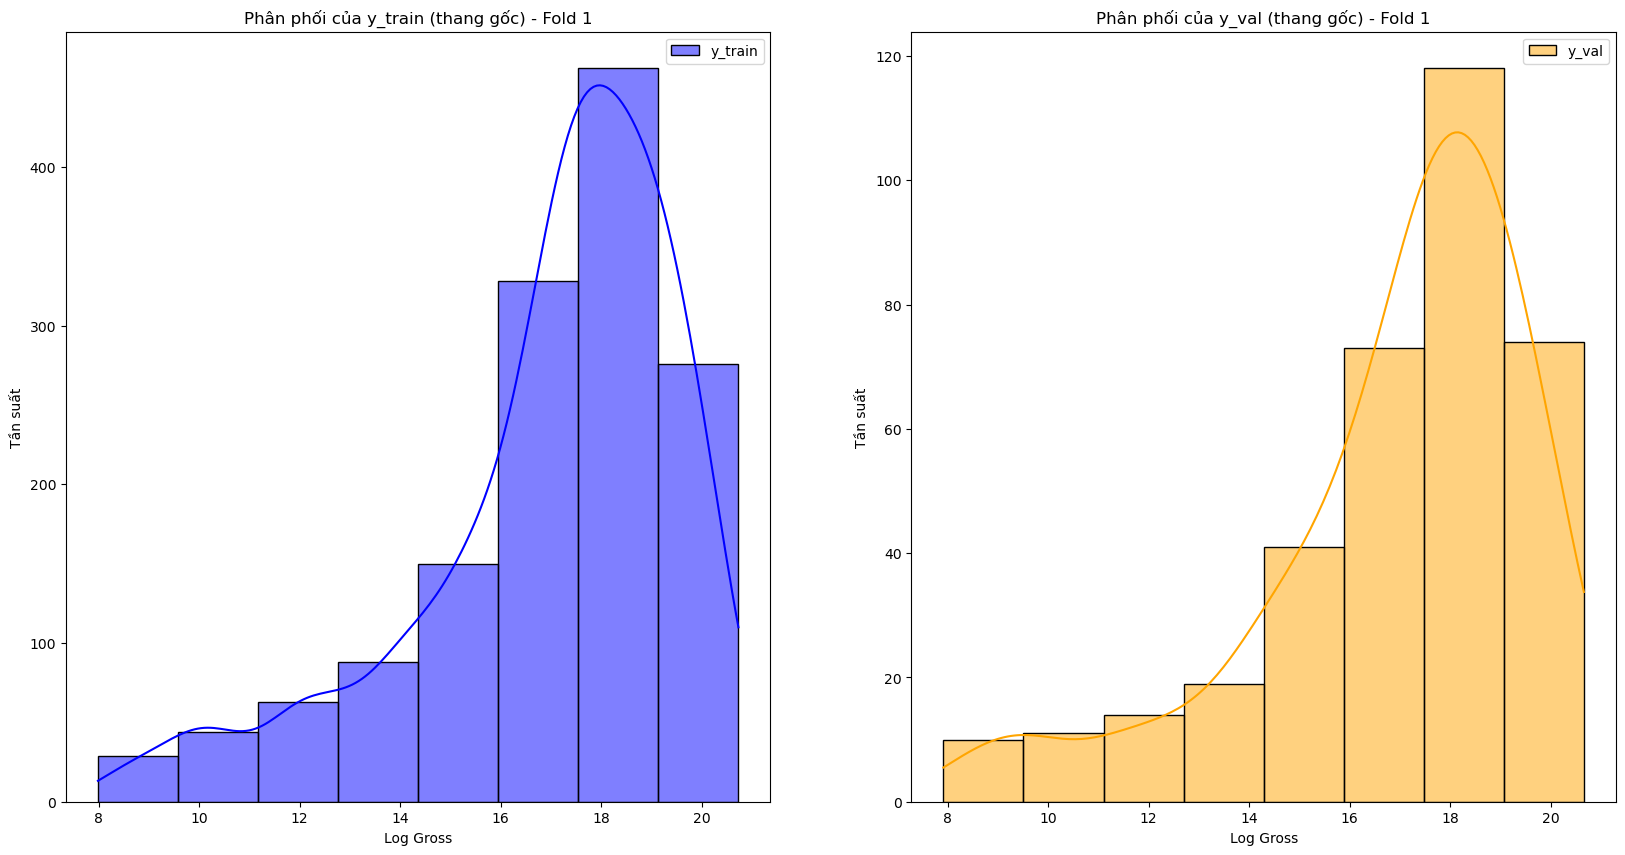

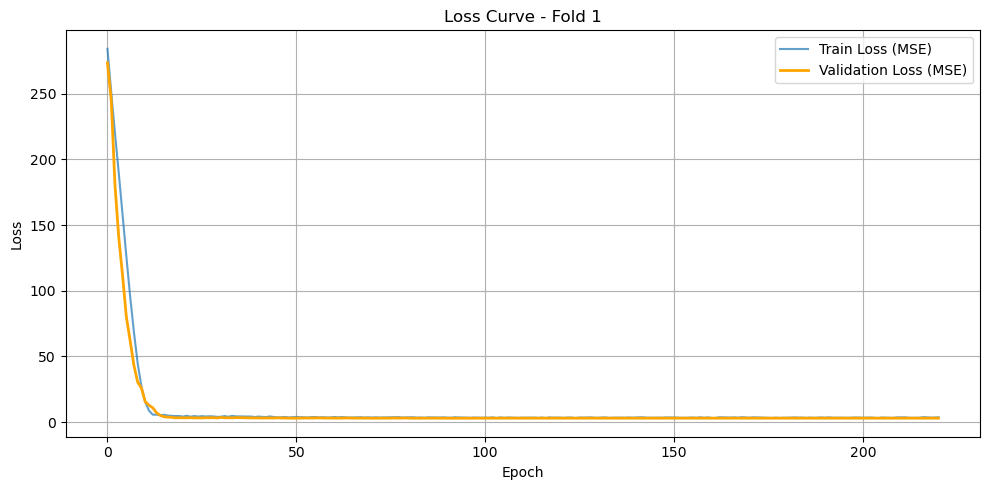

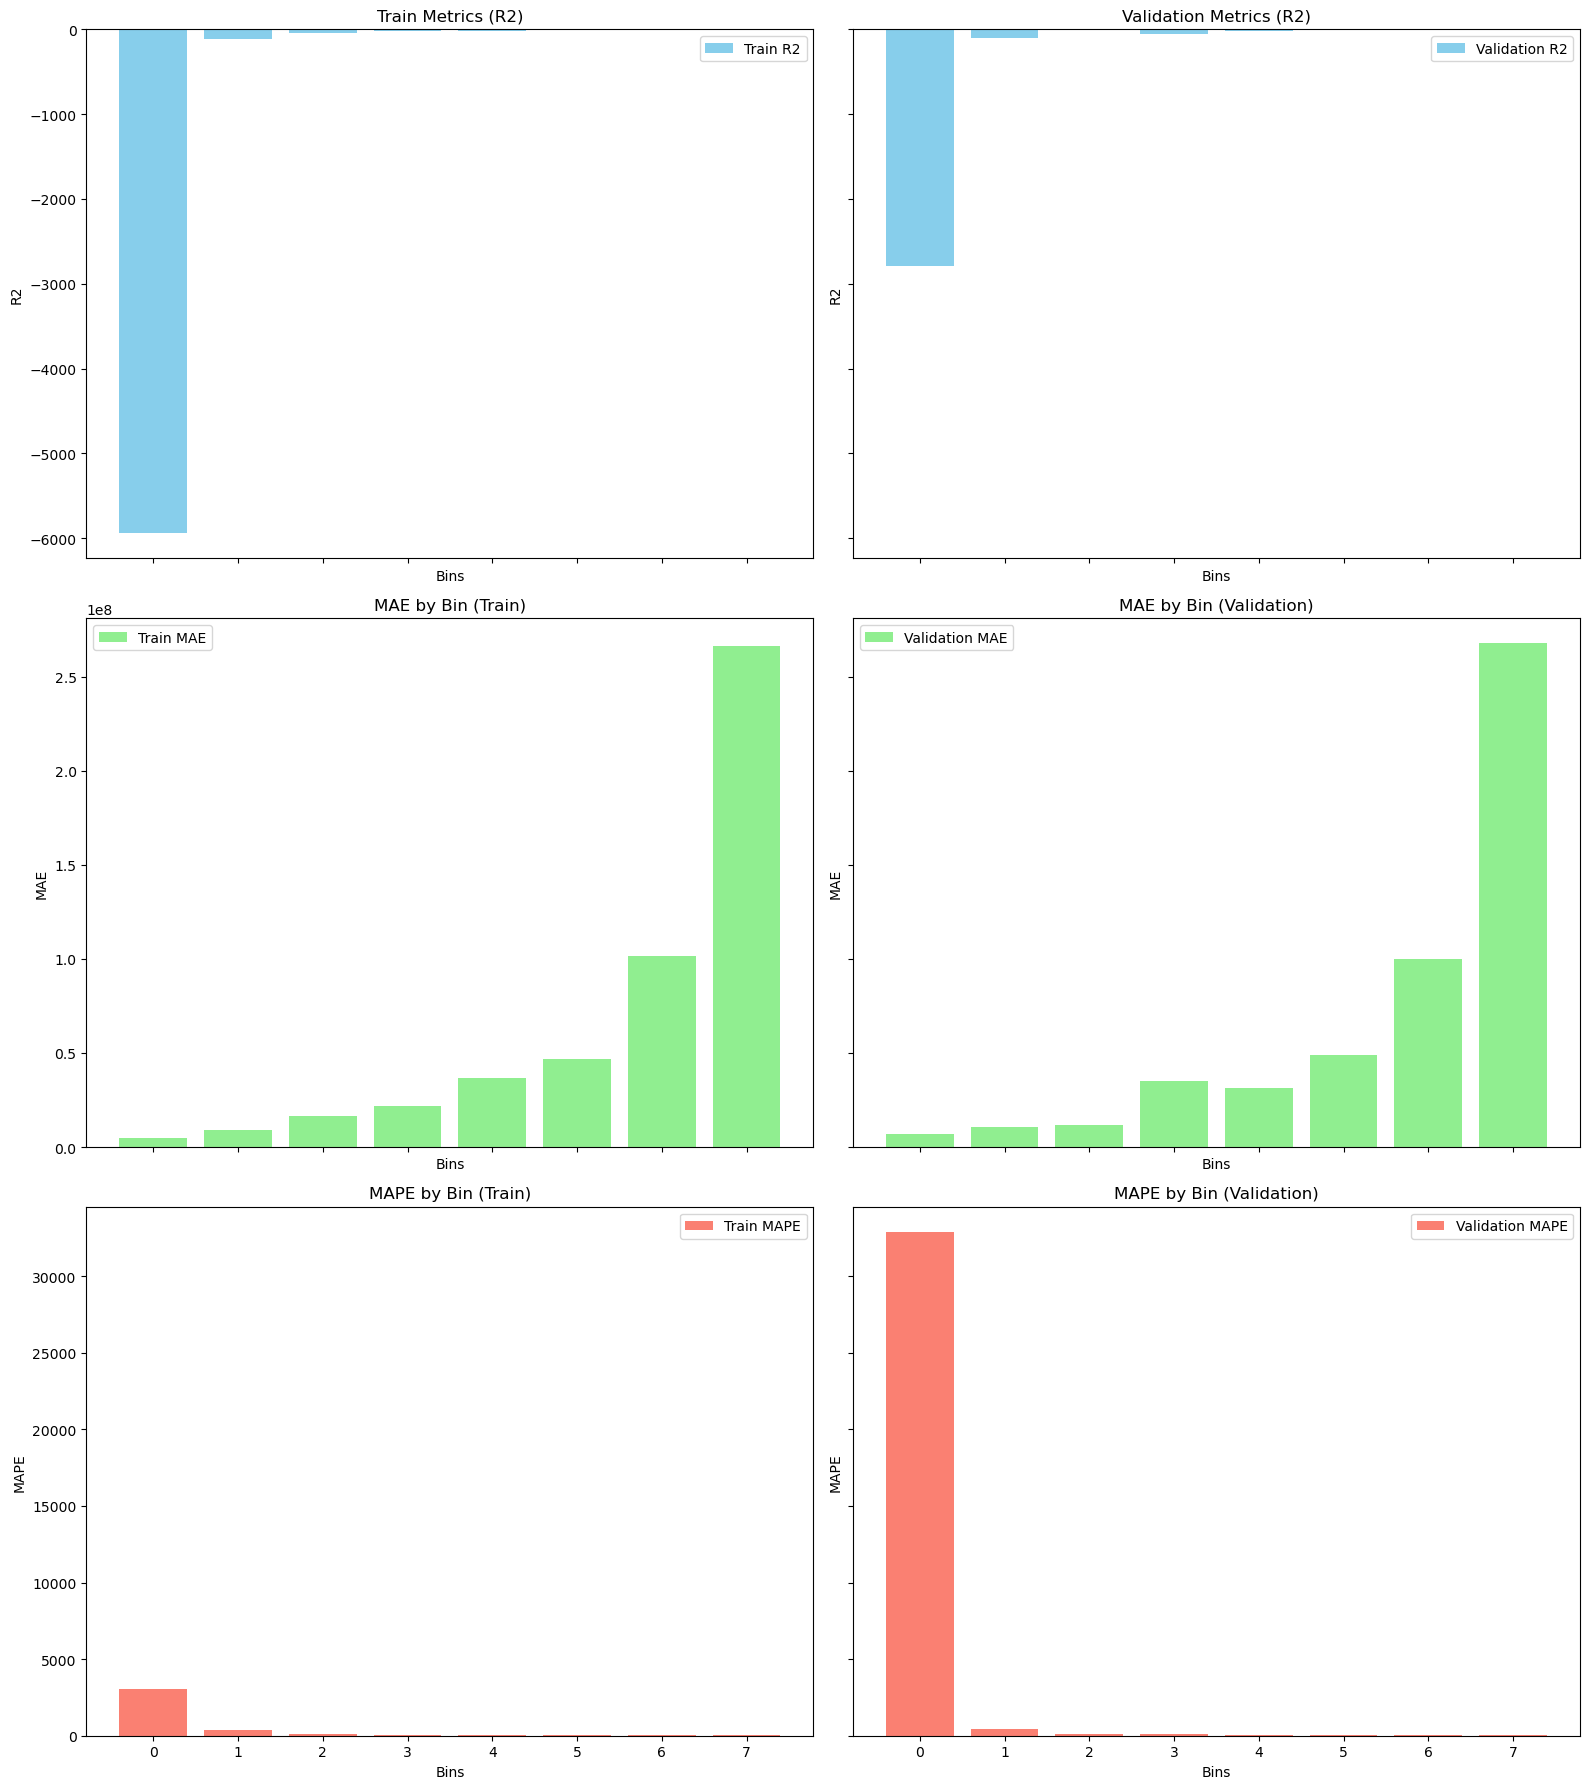

   Bin           R2          MAE         MAPE
0    0 -5938.516113    4594064.0  3078.170586
1    1  -115.599663    8904463.0   397.933626
2    2   -47.153919   16626116.0   119.045019
3    3   -21.565107   21583328.0    69.196796
4    4   -17.995378   36592392.0    63.809645
5    5    -6.854701   46853728.0    42.068210
6    6    -6.731334  101836616.0    47.688052
7    7    -1.577657  266385904.0    48.224461
   Bin           R2          MAE          MAPE
0    0 -2788.474121    6755546.5  32882.937622
1    1  -106.330551   10449026.0    425.973606
2    2   -12.852938   11968903.0     88.250011
3    3   -53.778198   35082476.0    115.387213
4    4   -14.286771   31527060.0     52.458328
5    5    -7.756431   49061024.0     46.020246
6    6   -10.023008   99996560.0     47.334421
7    7    -1.478797  267921088.0     47.403735
Fold 2
✅ Scaler saved to: H:\python\best_models\neural_net\fold_2\scaler.pkl
Early stopping at epoch 213


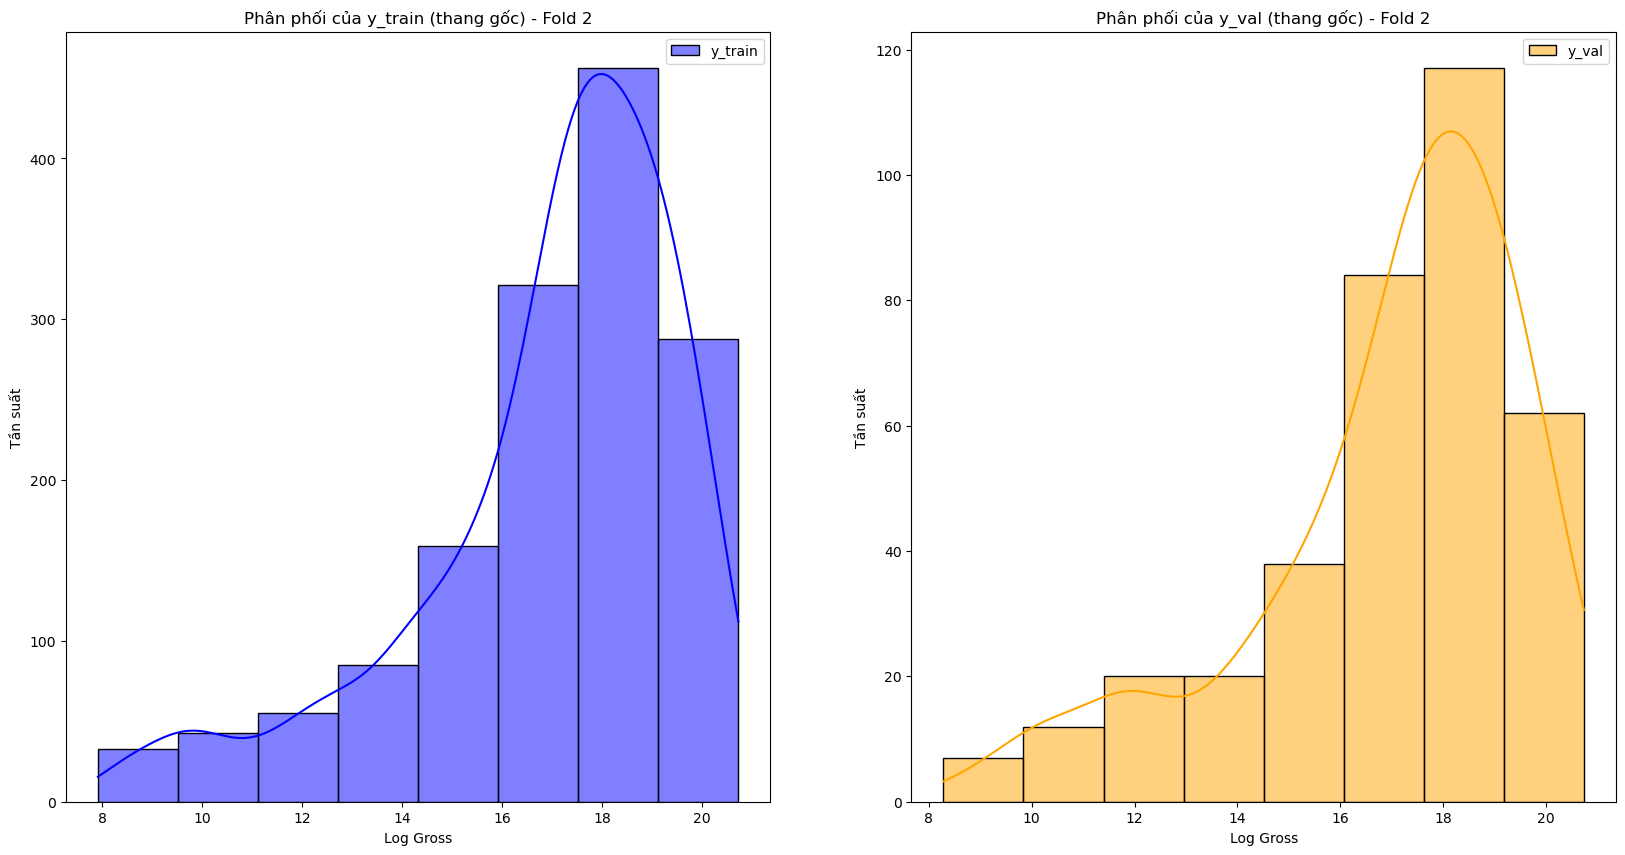

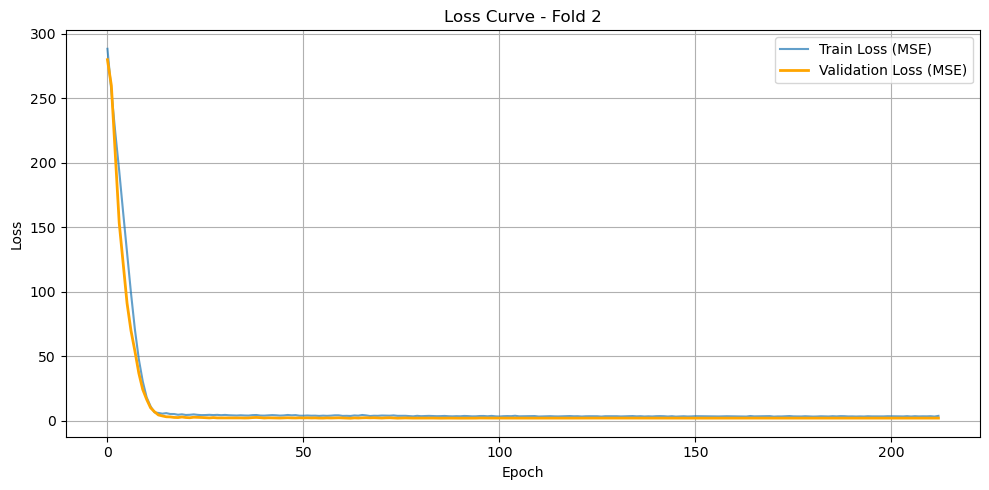

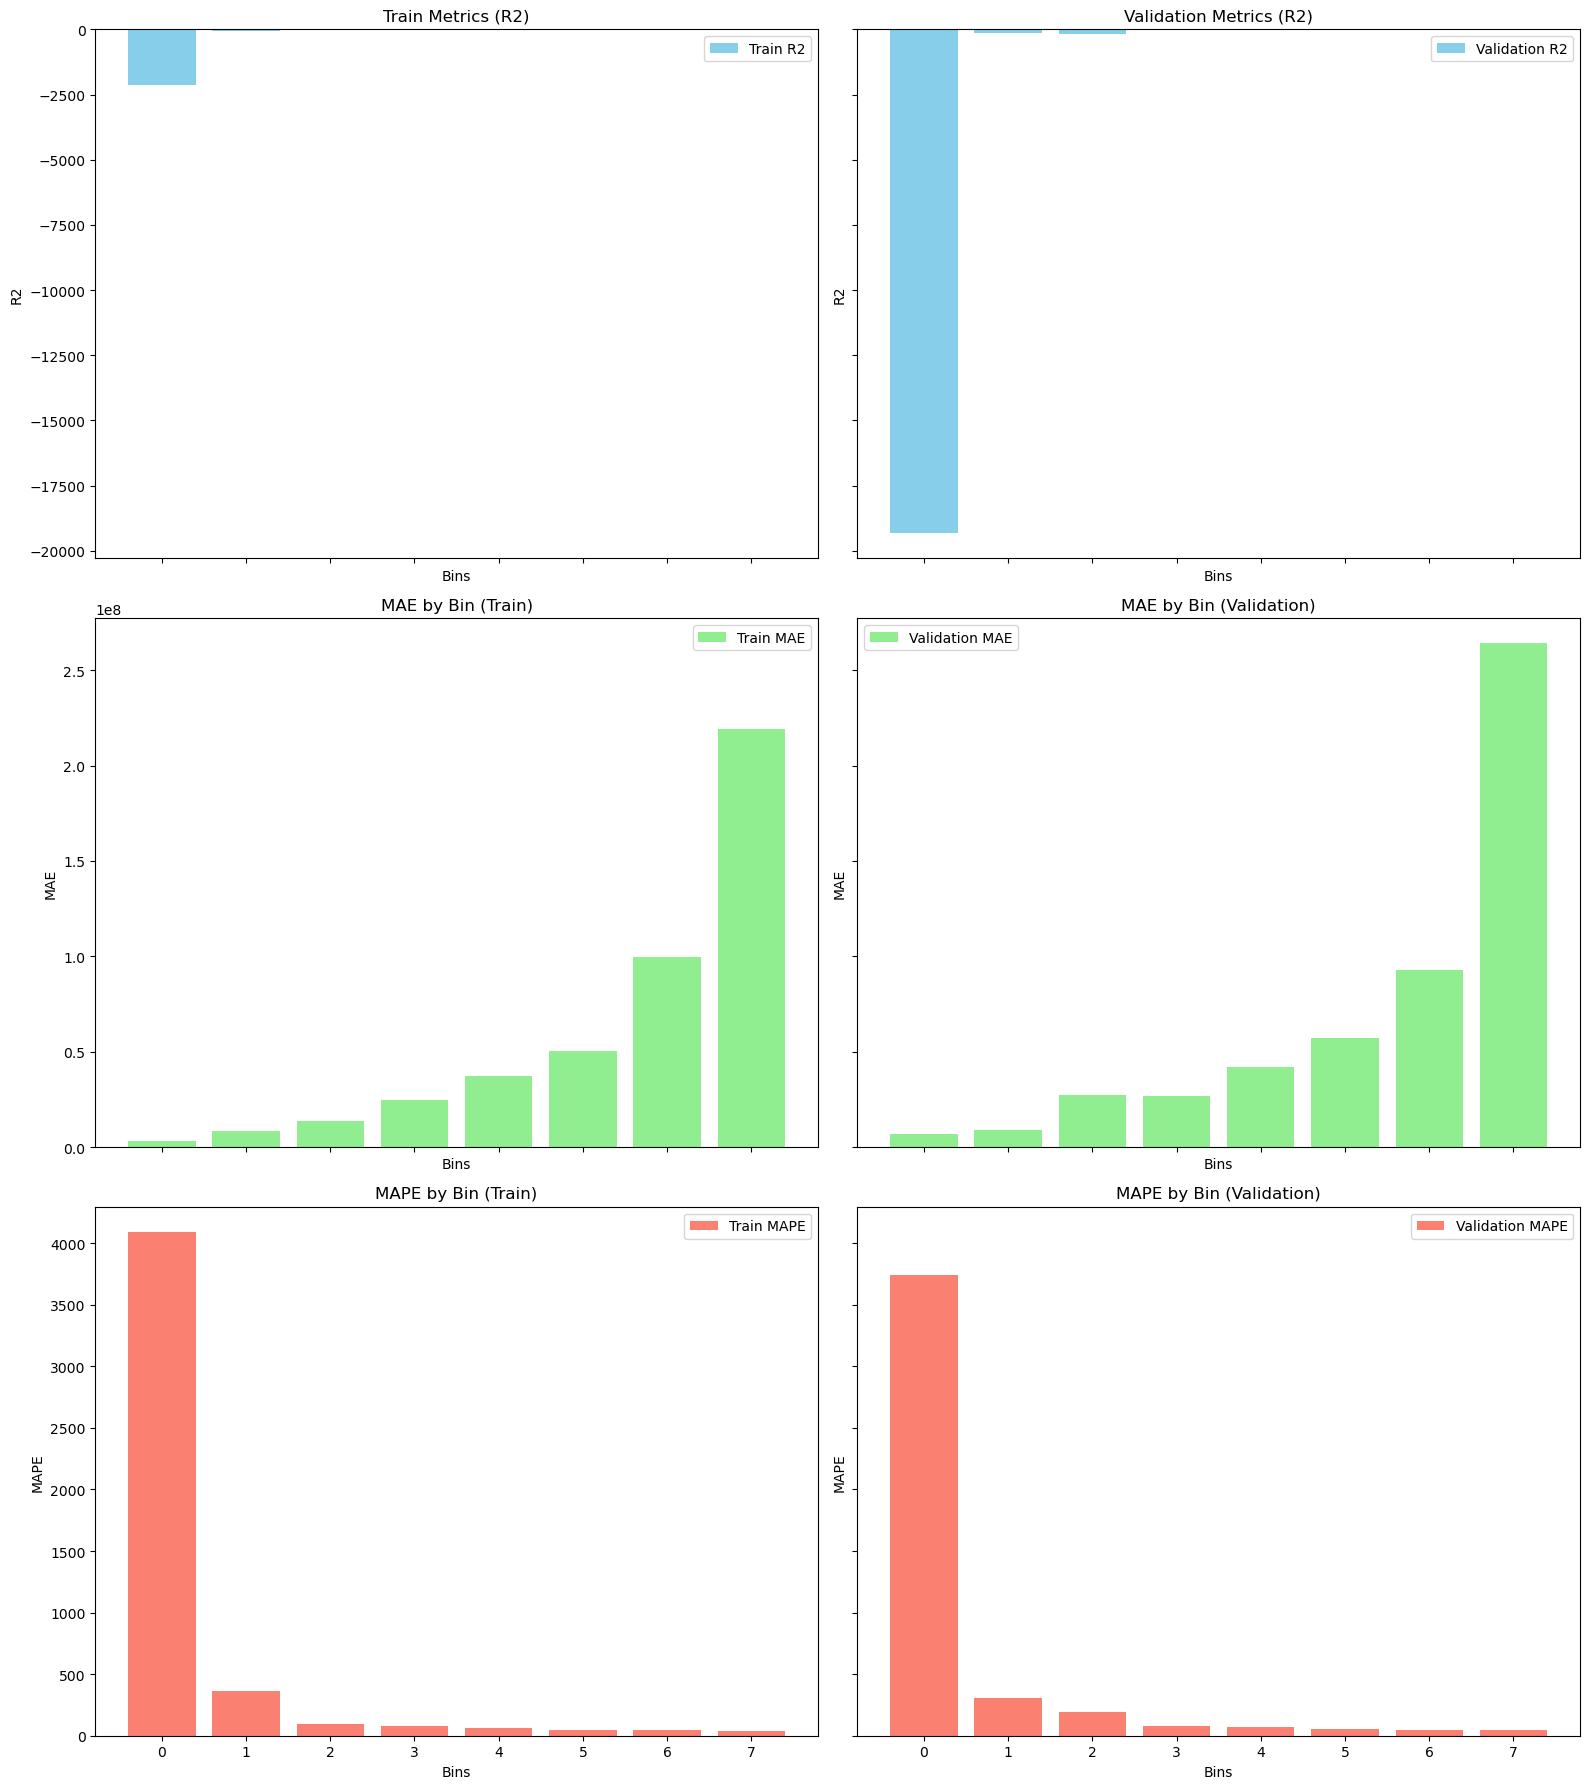

   Bin           R2           MAE         MAPE
0    0 -2121.041992  3.359984e+06  4090.872955
1    1   -80.289146  8.137258e+06   365.964317
2    2   -21.109812  1.344810e+07    96.047568
3    3   -32.313770  2.486079e+07    81.109059
4    4   -17.730389  3.709670e+07    64.297122
5    5    -8.942576  5.021664e+07    45.790711
6    6    -7.467818  9.940326e+07    45.857731
7    7    -0.969801  2.191721e+08    41.335243
   Bin            R2          MAE         MAPE
0    0 -19322.195312    6643319.5  3743.370056
1    1   -126.564804    8923533.0   309.398770
2    2   -163.404343   27197014.0   192.474127
3    3    -31.707253   26765030.0    80.625612
4    4    -26.812469   41785276.0    71.711612
5    5     -8.466959   57423844.0    50.883281
6    6     -5.222781   92689208.0    46.026570
7    7     -1.118755  264201872.0    48.897460
Fold 3
✅ Scaler saved to: H:\python\best_models\neural_net\fold_3\scaler.pkl
Early stopping at epoch 165


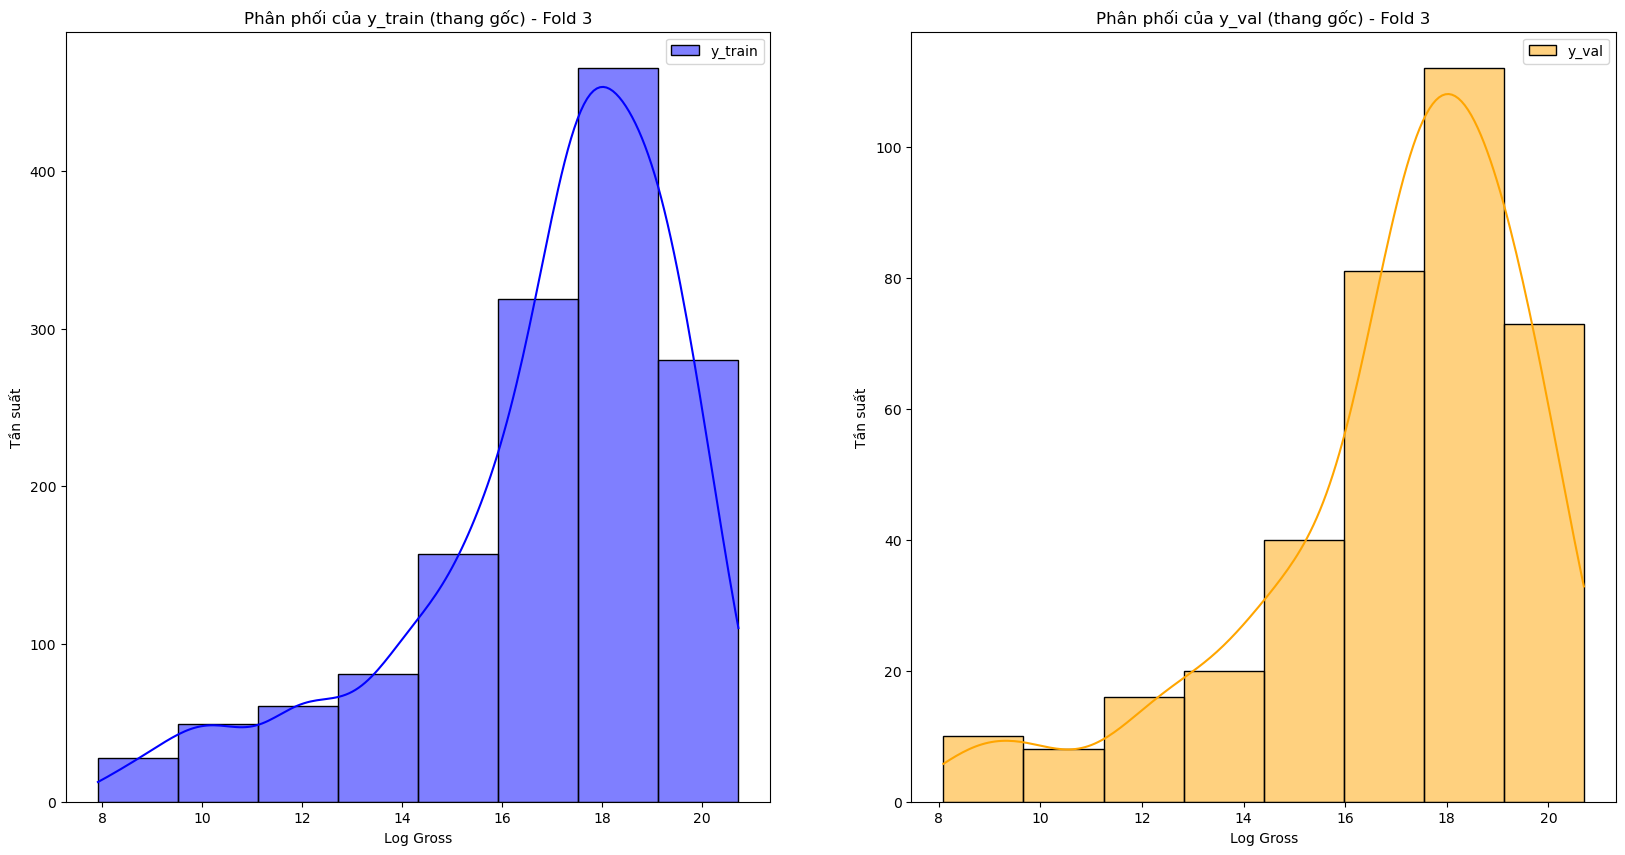

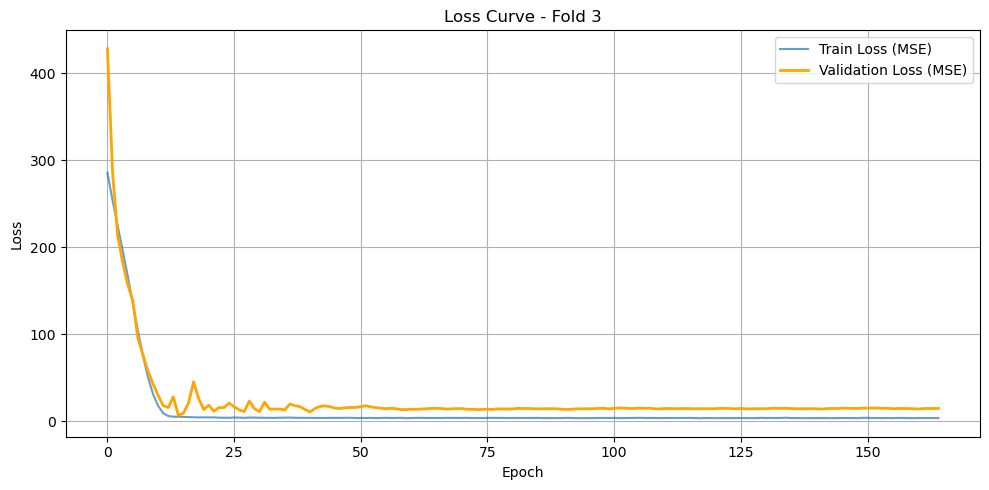

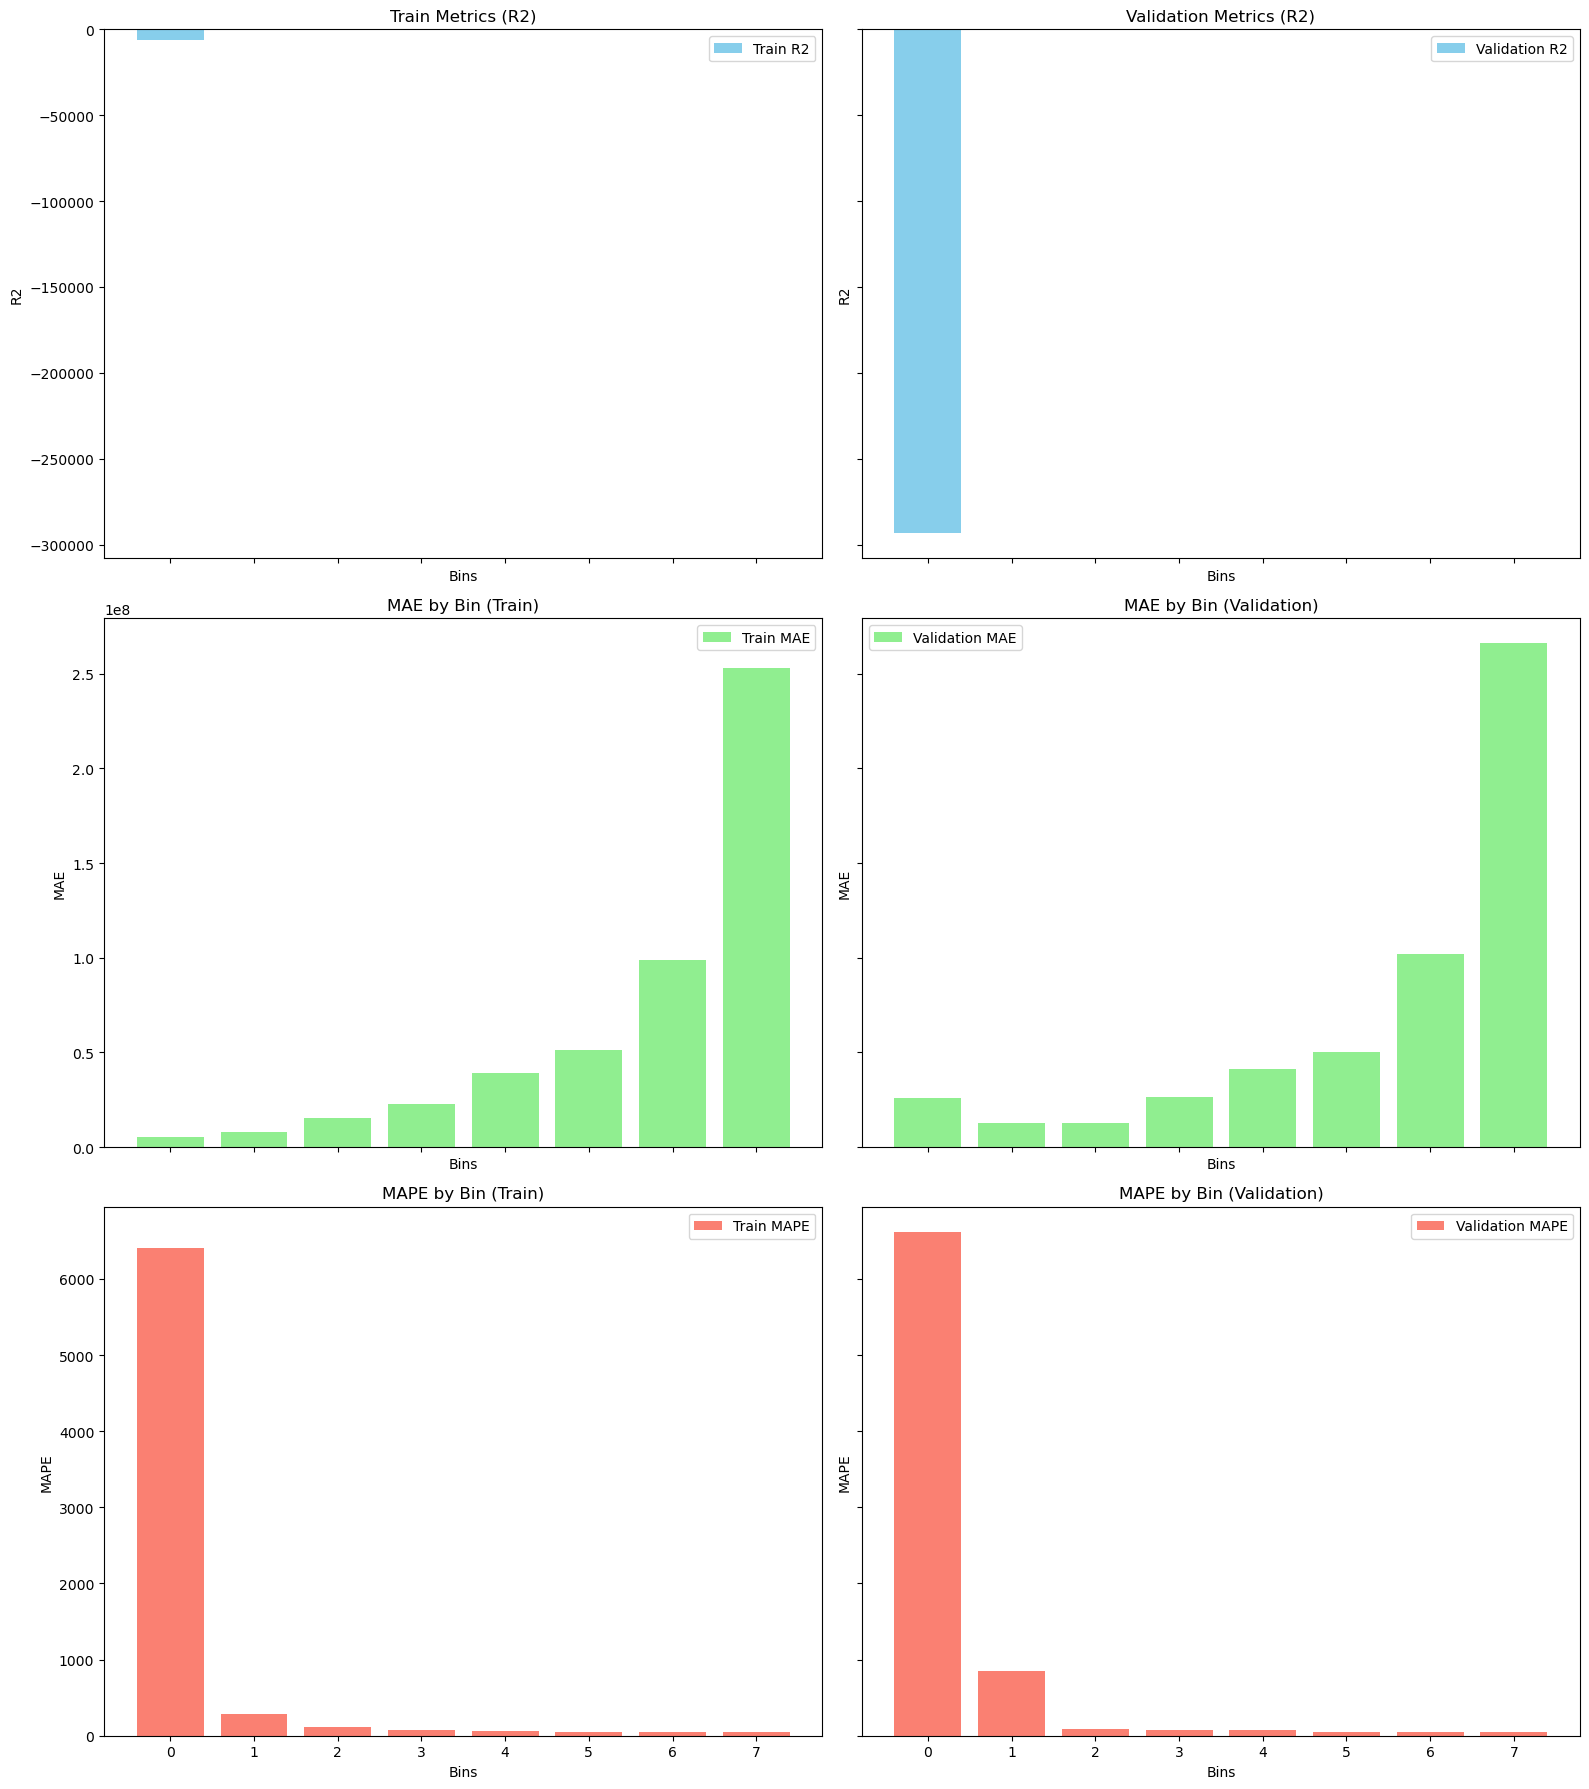

   Bin           R2          MAE         MAPE
0    0 -6016.055664    5032084.5  6406.876373
1    1   -51.616776    7734656.0   289.390874
2    2   -48.366280   15219035.0   108.501303
3    3   -25.694534   22958964.0    73.301542
4    4   -22.104588   39053416.0    67.753196
5    5    -7.481766   51229200.0    46.807998
6    6    -7.027951   98539872.0    46.582782
7    7    -1.304222  253149920.0    46.437505
   Bin             R2          MAE         MAPE
0    0 -293287.218750   25652896.0  6617.813110
1    1    -452.069519   12827763.0   856.275749
2    2     -15.346697   12866395.0    85.025299
3    3     -32.907269   26200766.0    81.449294
4    4     -18.612209   40980152.0    69.745278
5    5     -12.312548   50088136.0    45.161238
6    6      -6.632880  101805544.0    46.231198
7    7      -1.731553  266107152.0    44.247809
Fold 4
✅ Scaler saved to: H:\python\best_models\neural_net\fold_4\scaler.pkl
Early stopping at epoch 371


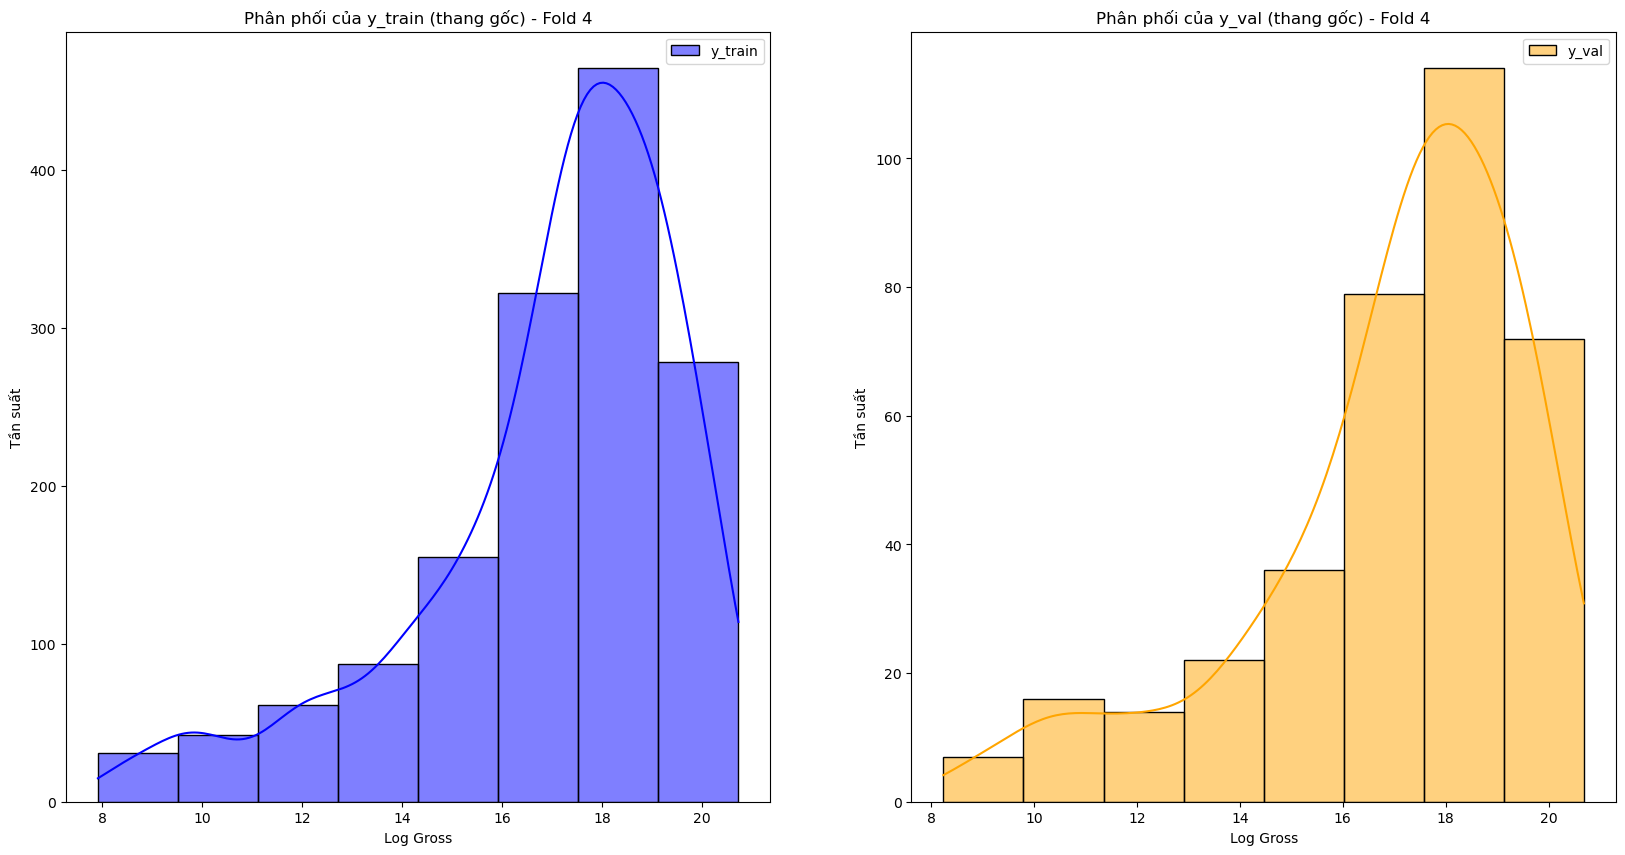

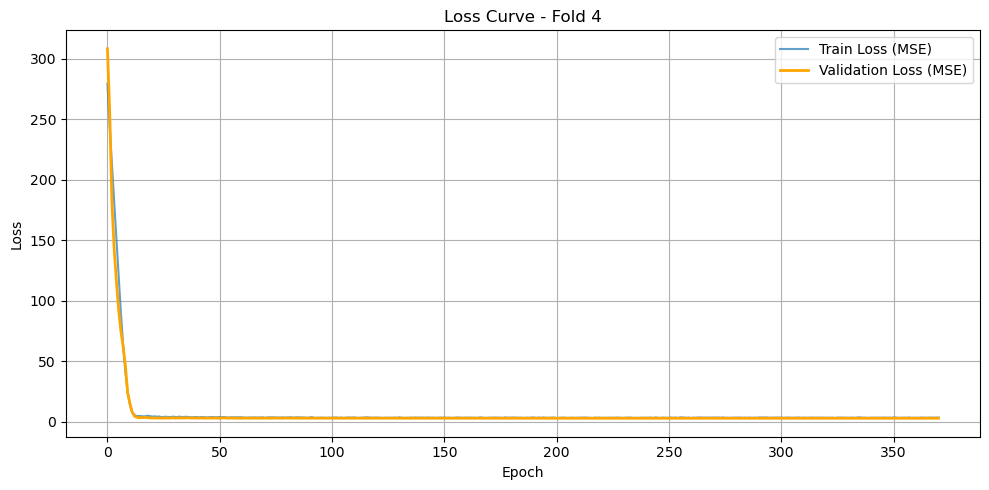

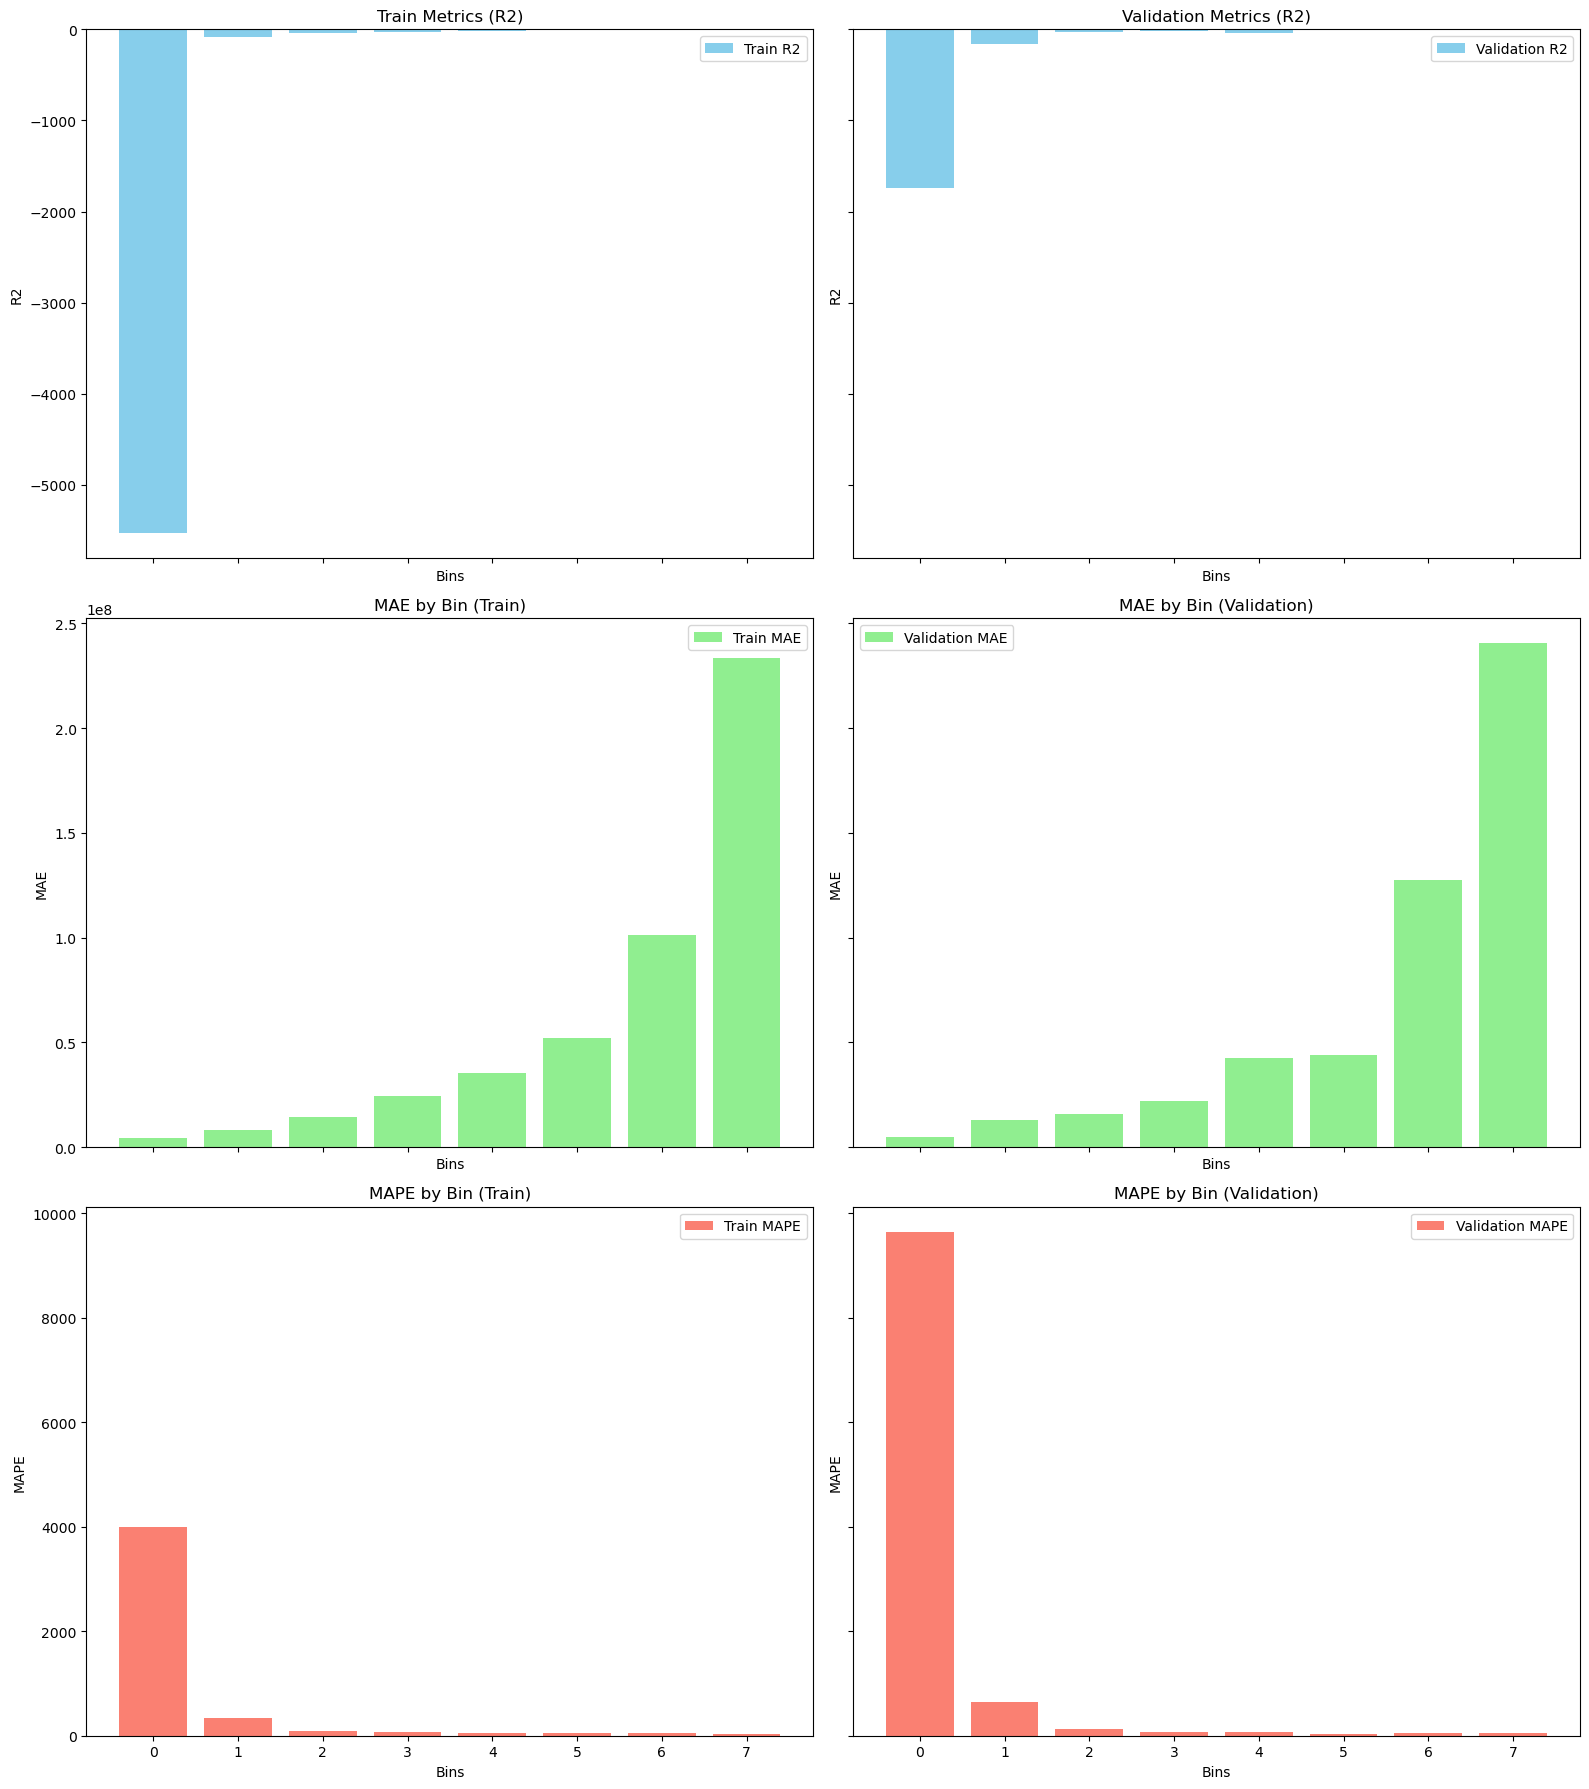

   Bin           R2          MAE         MAPE
0    0 -5529.732910    4310744.0  4000.433350
1    1   -88.984818    7979365.0   331.803679
2    2   -38.415005   14230558.0    99.736190
3    3   -32.163727   24568740.0    77.667660
4    4   -17.830660   35353872.0    61.166769
5    5    -8.284724   51974424.0    47.244847
6    6    -7.225234  101218304.0    47.592494
7    7    -1.049717  233420752.0    41.600749
   Bin           R2          MAE         MAPE
0    0 -1738.801514    4637342.0  9642.609406
1    1  -157.665710   12874611.0   639.130402
2    2   -31.993183   15897084.0   121.398652
3    3   -21.062588   21972452.0    74.234807
4    4   -37.882462   42638940.0    72.777718
5    5    -7.135824   43863320.0    40.602255
6    6   -10.941830  127387280.0    58.914399
7    7    -1.465663  240530368.0    48.284042
Fold 5
✅ Scaler saved to: H:\python\best_models\neural_net\fold_5\scaler.pkl
Early stopping at epoch 335


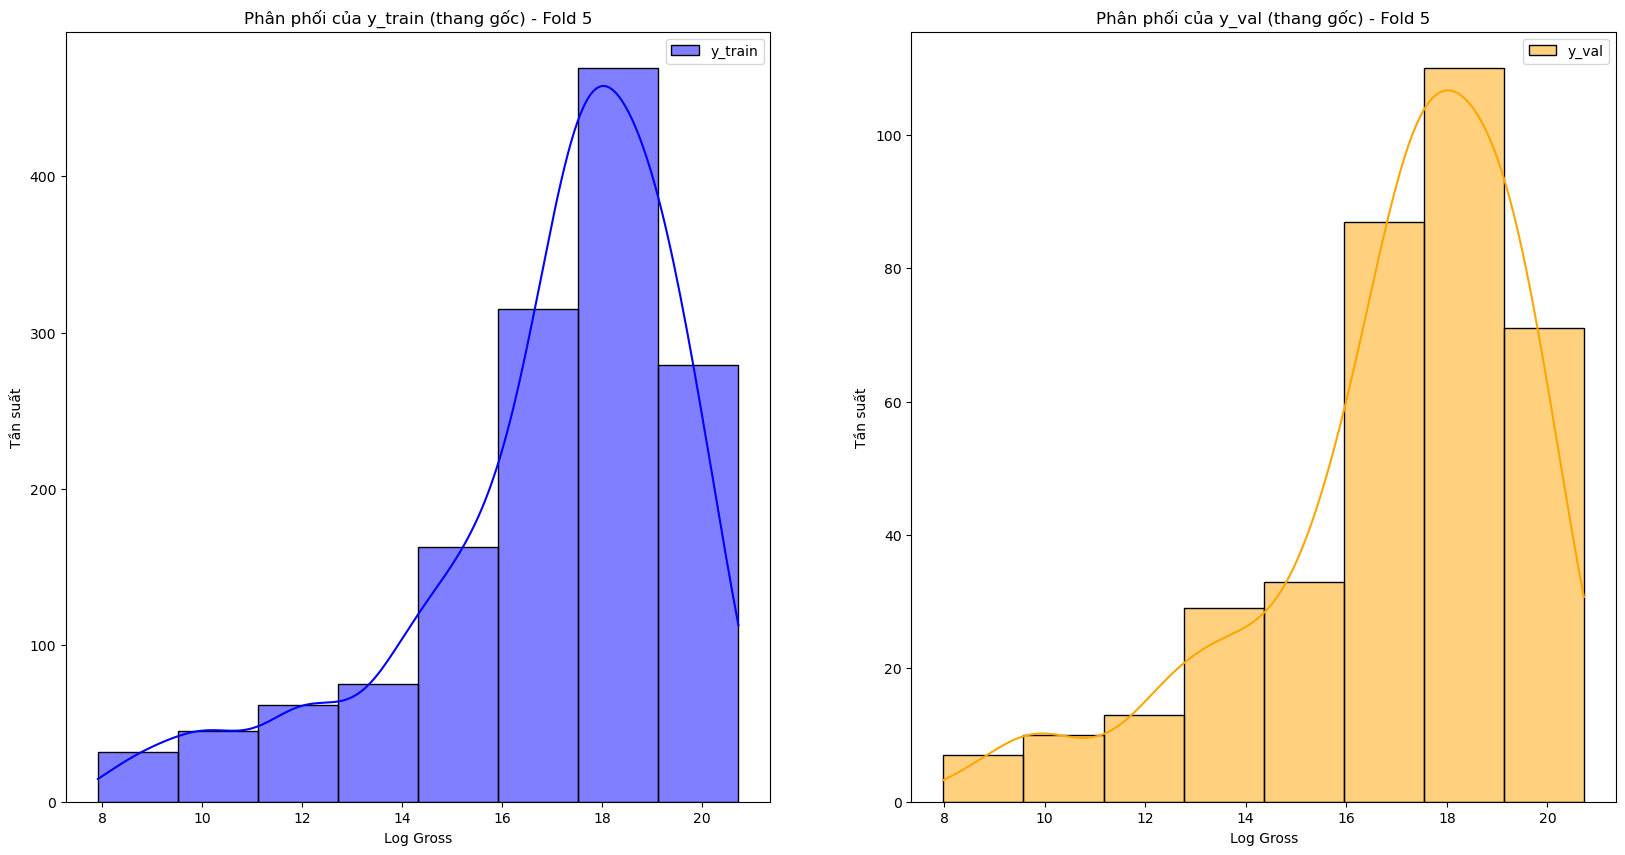

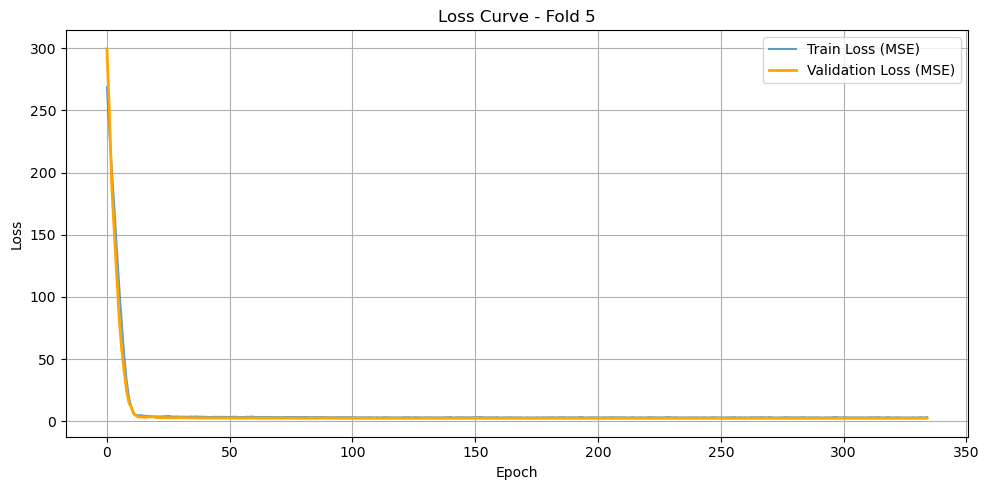

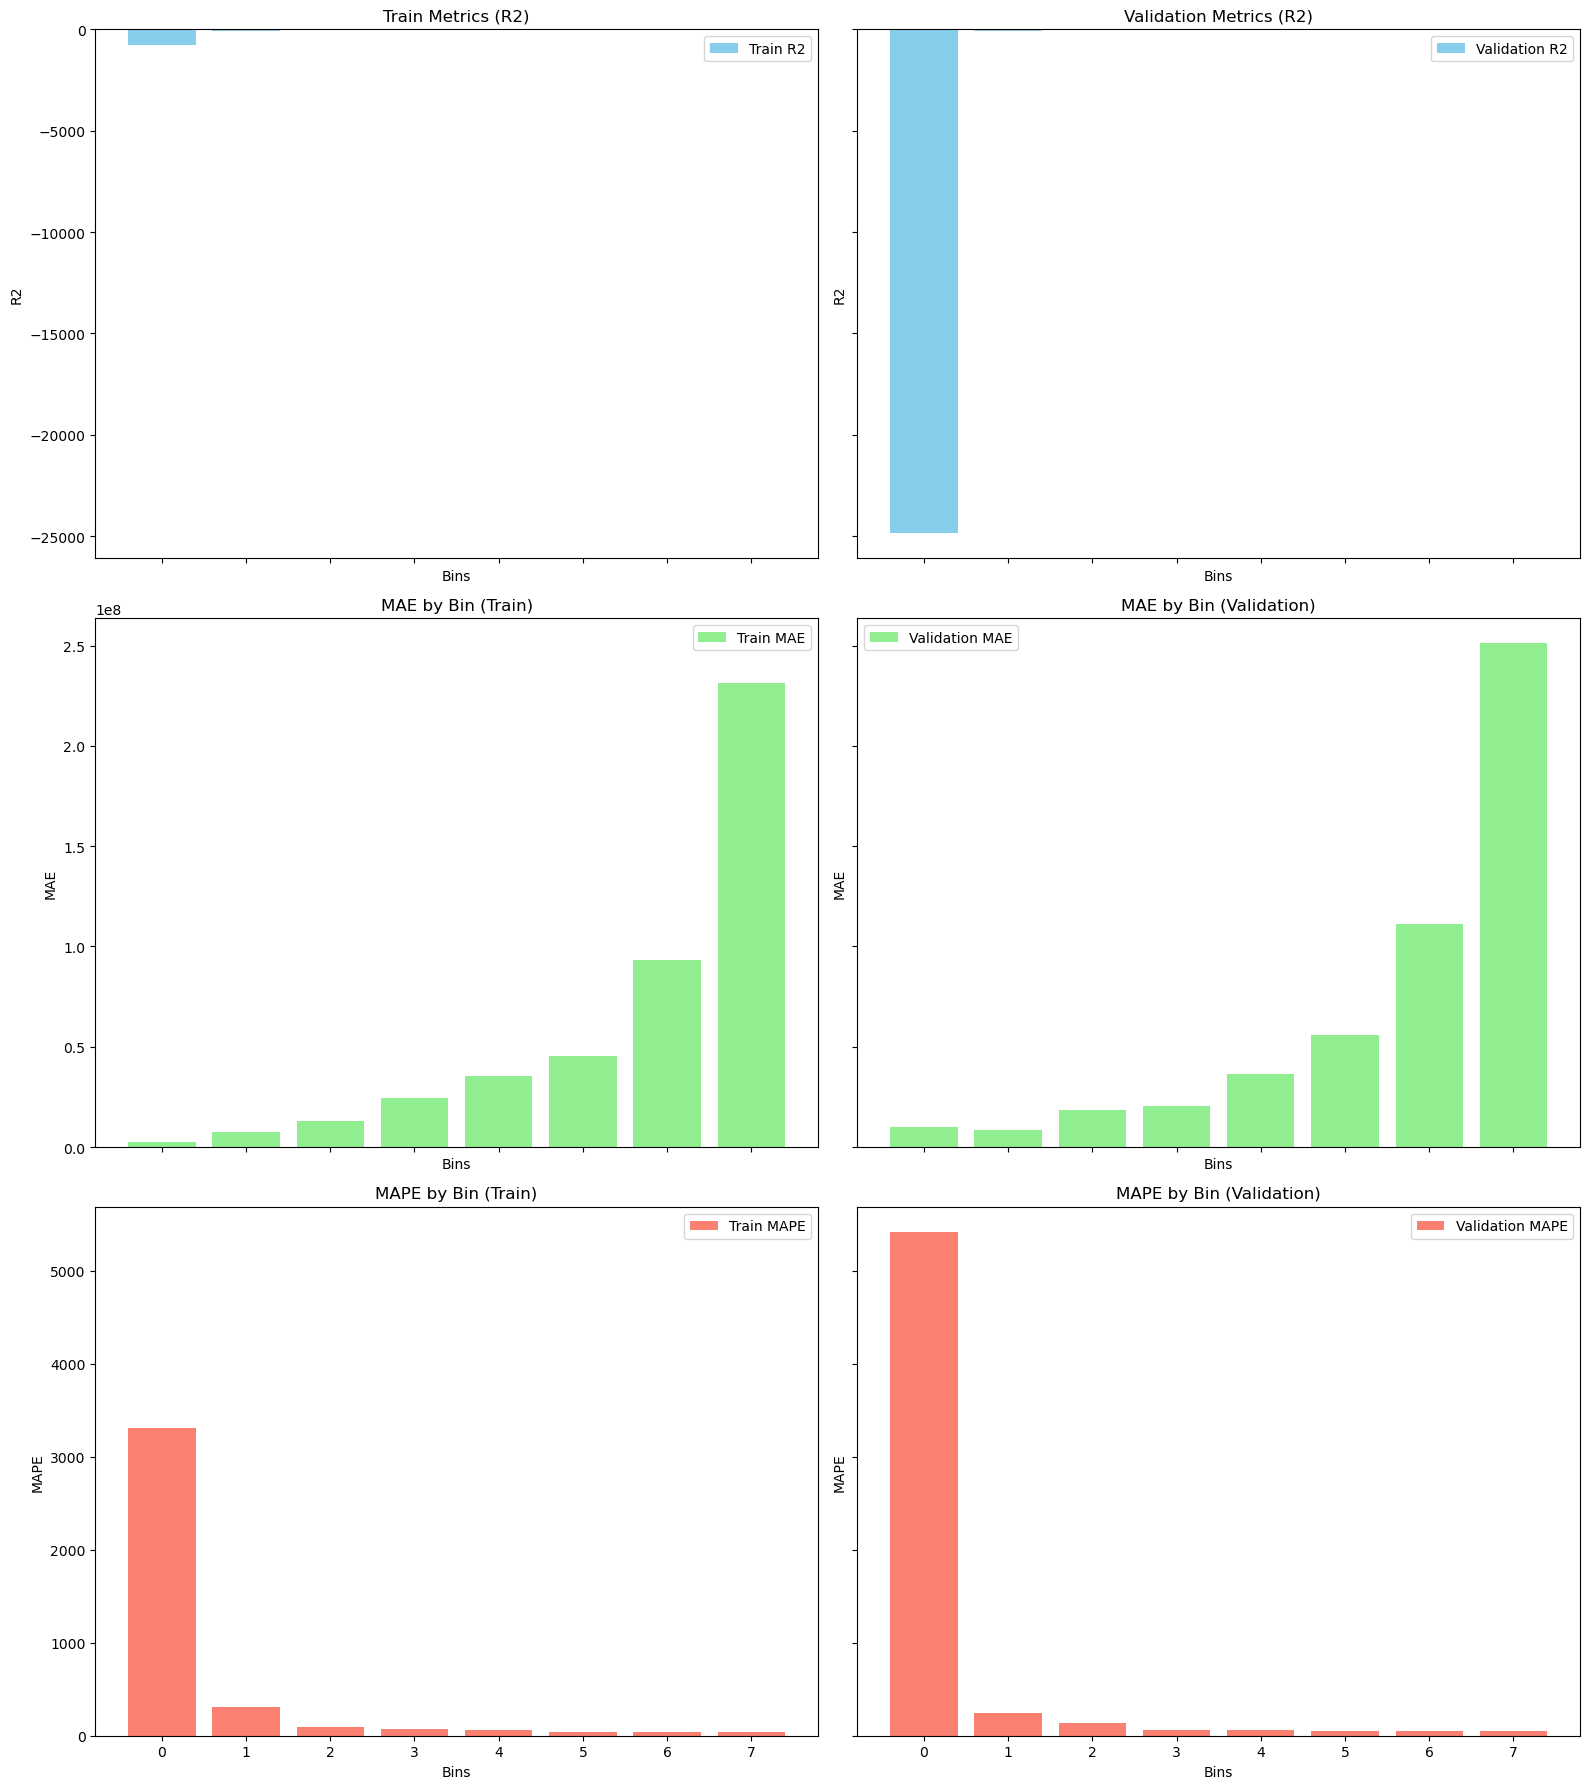

   Bin          R2           MAE         MAPE
0    0 -791.025391  2.313176e+06  3314.082718
1    1  -62.137306  7.419008e+06   308.619785
2    2  -27.855652  1.303874e+07    91.714764
3    3  -29.159235  2.428508e+07    77.607423
4    4  -17.331961  3.532842e+07    60.796553
5    5   -6.909428  4.549780e+07    41.581899
6    6   -6.116954  9.303608e+07    43.665075
7    7   -0.906995  2.312269e+08    42.713627
   Bin            R2          MAE         MAPE
0    0 -24849.031250   10174866.0  5417.885590
1    1    -63.248985    8581623.0   241.859293
2    2    -42.304817   18565820.0   134.711099
3    3    -19.578104   20642238.0    66.601980
4    4    -19.499859   36279708.0    65.142125
5    5    -10.433054   55773228.0    49.511561
6    6     -8.904134  111086544.0    50.251728
7    7     -1.789866  251171744.0    46.939015

===== Cross-Validation Average Results =====
Avg R²: nan (±nan)
Avg MAPE Loss: nan (±nan)


C:\Users\huynh\.conda\envs\movie-analyst\Lib\site-packages\numpy\core\fromnumeric.py:3504: RuntimeWarning: Mean of empty slice.
  return _methods._mean(a, axis=axis, dtype=dtype,
C:\Users\huynh\.conda\envs\movie-analyst\Lib\site-packages\numpy\core\_methods.py:129: RuntimeWarning: invalid value encountered in scalar divide
  ret = ret.dtype.type(ret / rcount)
C:\Users\huynh\.conda\envs\movie-analyst\Lib\site-packages\numpy\core\_methods.py:206: RuntimeWarning: Degrees of freedom <= 0 for slice
  ret = _var(a, axis=axis, dtype=dtype, out=out, ddof=ddof,
C:\Users\huynh\.conda\envs\movie-analyst\Lib\site-packages\numpy\core\_methods.py:163: RuntimeWarning: invalid value encountered in divide
  arrmean = um.true_divide(arrmean, div, out=arrmean,
C:\Users\huynh\.conda\envs\movie-analyst\Lib\site-packages\numpy\core\_methods.py:198: RuntimeWarning: invalid value encountered in scalar divide
  ret = ret.dtype.type(ret / rcount)


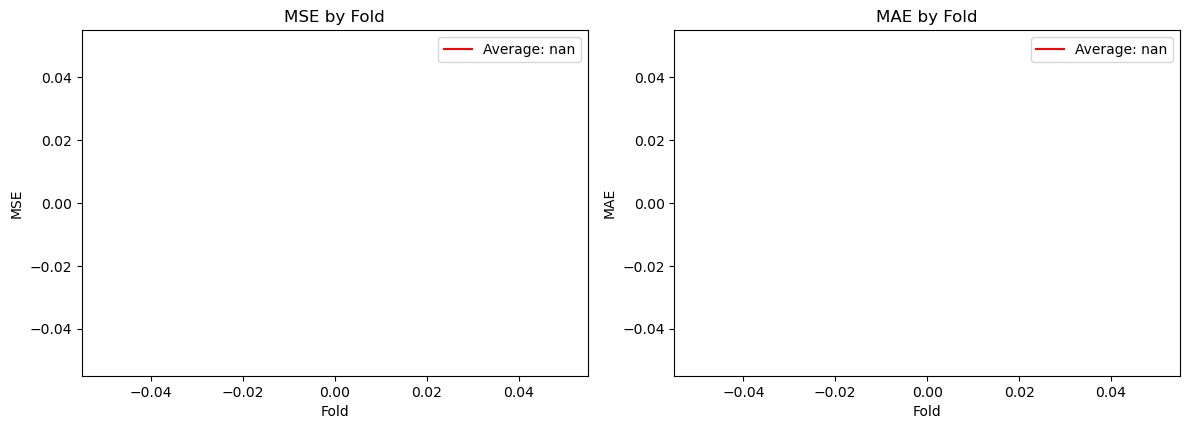

In [4]:
from settings import FEATURES, TARGET
skf = StratifiedKFold(n_splits=5, shuffle=True, random_state=42)

BEST_MODEL_DIR = os.path.join(BASE_DIR, "best_models")
os.makedirs(BEST_MODEL_DIR, exist_ok=True)

all_fold_r2 = []
all_fold_mape = []

for fold, (train_idx, val_idx) in enumerate(skf.split(df, df['log_gross_bin'])):
    print(f"Fold {fold + 1}")

    df_train = df.iloc[train_idx].copy()
    df_val = df.iloc[val_idx].copy()

    X_train, y_train, X_val, y_val = processing_data(df_train, df_val, fold=fold, features=FEATURES, target=TARGET, model_name="neural_net")


    X_train_tensor = torch.tensor(X_train, dtype=torch.float32)
    y_train_tensor = torch.tensor(y_train, dtype=torch.float32).view(-1, 1)
    X_val_tensor = torch.tensor(X_val, dtype=torch.float32)
    y_val_tensor = torch.tensor(y_val, dtype=torch.float32).view(-1, 1)

    # Tạo DataLoader
    train_dataset = TensorDataset(X_train_tensor, y_train_tensor)
    train_loader = DataLoader(train_dataset, batch_size=BATCH_SIZE, shuffle=True)



    # Khởi tạo mô hình, loss và optimizer
    model = Net(X_train.shape[1]).to(DEVICE)
    criterion = nn.MSELoss().to(DEVICE)
    optimizer = optim.Adam(model.parameters(), lr=LEARNING_RATE)

    train_losses = []
    val_losses = []

    best_val_loss = float('inf')
    patience_counter = 0
    save_path = os.path.join(BEST_MODEL_DIR, "neural_net",f"fold_{fold + 1}")
    best_model_path = os.path.join(save_path, "model.pt")
    os.makedirs(save_path, exist_ok=True)
    scheduler = optim.lr_scheduler.ReduceLROnPlateau(optimizer, mode='min', patience=10, factor=0.5)

    # Huấn luyện
    for epoch in range(2000):
        model.train()
        train_epoch_loss = 0
        for batch_X, batch_y in train_loader:
            batch_X, batch_y = batch_X.to(DEVICE), batch_y.to(DEVICE)
            optimizer.zero_grad()
            outputs = model(batch_X)
            loss = criterion(outputs, batch_y)
            loss.backward()
            optimizer.step()
            train_epoch_loss += loss.item()
        train_losses.append(train_epoch_loss / len(train_loader))


        # Đánh giá
        model.eval()
        with torch.no_grad():
            val_preds = model(X_val_tensor.to(DEVICE))
            val_loss = criterion(val_preds, y_val_tensor.to(DEVICE)).item()
            val_losses.append(val_loss)
            scheduler.step(val_loss)

        if val_loss < best_val_loss:
            best_val_loss = val_loss
            torch.save(model.state_dict(), best_model_path)
            patience_counter = 0
        else:
            patience_counter += 1

        if patience_counter >= PATIENCE:
            print(f"Early stopping at epoch {epoch+1}")
            break

    # Vẽ train và val loss
    plt.figure(figsize=(10, 5))
    plt.plot(range(len(train_losses)), train_losses, label="Train Loss (MSE)", alpha=0.7)
    plt.plot(range(len(val_losses)), val_losses, label="Validation Loss (MSE)", color='orange', linewidth=2)
    plt.xlabel("Epoch")
    plt.ylabel("Loss")
    plt.title(f"Loss Curve - Fold {fold + 1}")
    plt.legend()
    plt.grid(True)
    plt.tight_layout()
    plt.show()


    model.eval()
    with torch.no_grad():
        test_predictions = model(X_val_tensor.to(DEVICE))
        test_predictions = test_predictions.cpu().numpy().flatten()
        y_test = y_val_tensor.cpu().numpy().flatten()

        train_predictions = model(X_train_tensor.to(DEVICE))
        train_predictions = train_predictions.cpu().numpy().flatten()
        y_train = y_train_tensor.cpu().numpy().flatten()


        fig, axes = plt.subplots(3, 2, figsize=(16, 18), sharex=True, sharey='row')  # 3 rows (R2, MAE, MAPE), 2 columns (Train, Validation)

        # Gọi visualize_results cho tập Train và vẽ vào cột đầu tiên (Train)
        df_test_result = visualize_results(df_train, y_true=y_train, y_pred=train_predictions, calculate_real_target=True, dataset_label="Train", axes=axes[:, 0])

        # Gọi visualize_results cho tập Validation và vẽ vào cột thứ hai (Validation)
        df_val_result = visualize_results(df_val, y_true=y_test, y_pred=test_predictions, calculate_real_target=True, dataset_label="Validation", axes=axes[:, 1])

        # Cài đặt tiêu đề và hiển thị
        axes[0, 0].set_title("Train Metrics (R2)")  # Tiêu đề cho R2 Train
        axes[0, 1].set_title("Validation Metrics (R2)")  # Tiêu đề cho R2 Validation

        plt.tight_layout()
        plt.show()
        print(df_test_result)
        print(df_val_result)

        # all_fold_r2.append(test_r2)
        # all_fold_mape.append(test_mape)


avg_r2 = np.mean(all_fold_r2)
avg_mape = np.mean(all_fold_mape)

print("\n===== Cross-Validation Average Results =====")
print(f"Avg R²: {avg_r2:.4f} (±{np.std(all_fold_r2):.4f})")
print(f"Avg MAPE Loss: {avg_mape:.4f} (±{np.std(avg_mape):.4f})")

# Optionally, plot average metrics across folds
plt.figure(figsize=(12, 8))
fold_indices = list(range(1, len(all_fold_mape) + 1))

plt.subplot(2, 2, 1)
plt.bar(fold_indices, all_fold_r2)
plt.axhline(y=avg_r2, color='r', linestyle='-', label=f'Average: {avg_r2:.2f}')
plt.xlabel('Fold')
plt.ylabel('MSE')
plt.title('MSE by Fold')
plt.legend()

plt.subplot(2, 2, 2)
plt.bar(fold_indices, all_fold_mape)
plt.axhline(y=avg_mape, color='r', linestyle='-', label=f'Average: {avg_mape:.2f}')
plt.xlabel('Fold')
plt.ylabel('MAE')
plt.title('MAE by Fold')
plt.legend()



plt.tight_layout()
plt.show()
